In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load UFO dataset
import pandas as pd

# Load and prepare data
df = pd.read_csv('/content/drive/MyDrive/UFO/scrubbed_data.csv')
df = df.dropna(subset=['comments', 'country'])  # Ensure both text and label exist

# Clean location fields
df['country'] = df['country'].str.lower()
df['state'] = df['state'].str.upper()

# Text preprocessing
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_description'] = df['comments'].apply(clean_text)
df[['cleaned_description', 'country', 'state']].head()

<ipython-input-2-094a6a8171ea>:5: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/UFO/scrubbed_data.csv')


,cleaned_description,country,state
0,this event took place in early fall around 194...,us,TX
2,greenorange circular disc over chester44 england,gb,NaN
3,my older brother and twin sister were leaving ...,us,TX
4,as a marine 1st lt flying an fj4b fighterattac...,us,HI
5,my father is now 89 my brother 52 the girl wit...,us,TN


## Predicting Country

In [3]:
# Text vectorization and label encoding
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting COUNTRY from description
X = df['cleaned_description']
y = df['country']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [4]:
# Logistic Regression
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_vec, y_train_enc)

# Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_vec, y_train_enc)

# Evaluate Logistic Regression
y_pred_lr = clf_lr.predict(X_test_vec)
print("\nLogistic Regression Report (Country):")
print(classification_report(y_test_enc, y_pred_lr, target_names=le.classes_))

# Evaluate Random Forest
y_pred_rf = clf_rf.predict(X_test_vec)
print("\nRandom Forest Report (Country):")
print(classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))


Logistic Regression Report (Country):
              precision    recall  f1-score   support

          au       1.00      0.12      0.21       103
          ca       0.88      0.16      0.27       611
          de       0.00      0.00      0.00        23
          gb       0.91      0.17      0.29       352
          us       0.93      1.00      0.97     13041

    accuracy                           0.93     14130
   macro avg       0.75      0.29      0.35     14130
weighted avg       0.93      0.93      0.91     14130



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest Report (Country):
              precision    recall  f1-score   support

          au       0.83      0.18      0.30       103
          ca       0.71      0.20      0.32       611
          de       1.00      0.13      0.23        23
          gb       0.70      0.20      0.32       352
          us       0.94      0.99      0.97     13041

    accuracy                           0.93     14130
   macro avg       0.84      0.34      0.43     14130
weighted avg       0.92      0.93      0.92     14130



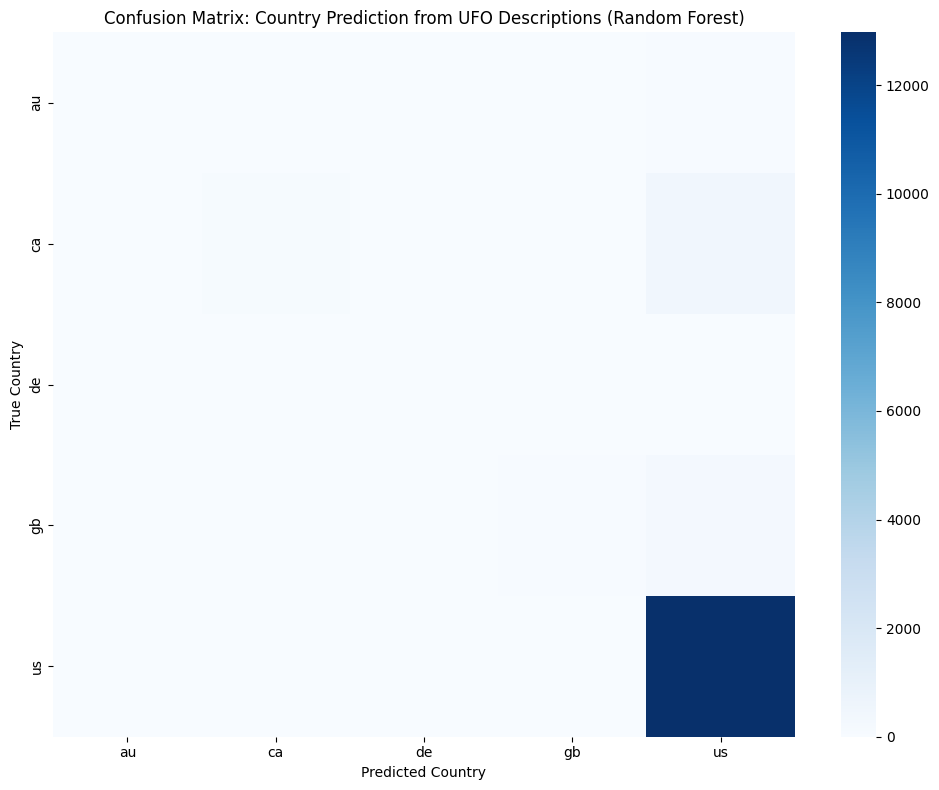

In [5]:
# Confusion matrix - Random Forest
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=False, xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix: Country Prediction from UFO Descriptions (Random Forest)')
plt.xlabel('Predicted Country')
plt.ylabel('True Country')
plt.tight_layout()
plt.show()

## Feature Importance Plot (Random Forest - Country)

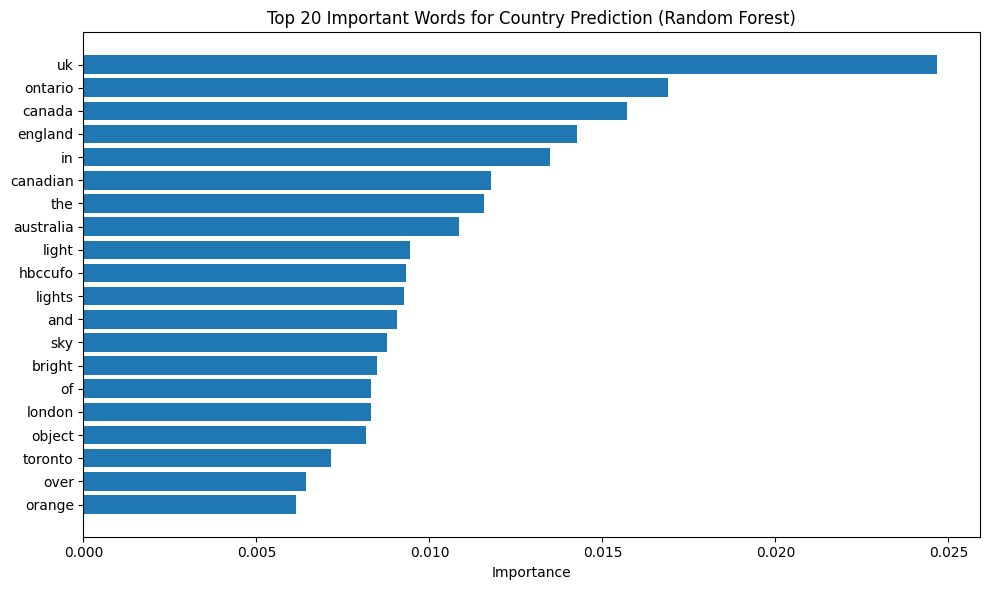

In [6]:
# Feature Importance Plot (Random Forest - Country)
import numpy as np

feature_names = vectorizer.get_feature_names_out()
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 20 Important Words for Country Prediction (Random Forest)')
plt.tight_layout()
plt.show()


## Predicting State

In [7]:
# Now Predicting STATE from description (US only)
df_us = df[df['country'] == 'us'].dropna(subset=['state'])
X_state = df_us['cleaned_description']
y_state = df_us['state']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_state, y_state, test_size=0.2, random_state=42)

X_train_vec_s = vectorizer.fit_transform(X_train_s)
X_test_vec_s = vectorizer.transform(X_test_s)

le_s = LabelEncoder()
y_train_enc_s = le_s.fit_transform(y_train_s)
y_test_enc_s = le_s.transform(y_test_s)

In [8]:
clf_rf_state = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_state.fit(X_train_vec_s, y_train_enc_s)

# Evaluate State Prediction
y_pred_s = clf_rf_state.predict(X_test_vec_s)
print("\nRandom Forest Report (State - US Only):")
print(classification_report(y_test_enc_s, y_pred_s, target_names=le_s.classes_))



Random Forest Report (State - US Only):
              precision    recall  f1-score   support

          AK       0.67      0.29      0.40        69
          AL       0.69      0.17      0.27       131
          AR       0.57      0.15      0.24       138
          AZ       0.60      0.33      0.43       484
          CA       0.19      0.78      0.30      1782
          CO       0.64      0.29      0.40       287
          CT       0.50      0.13      0.21       153
          DC       0.00      0.00      0.00         2
          DE       0.73      0.24      0.36        34
          FL       0.27      0.26      0.27       712
          GA       0.61      0.21      0.32       267
          HI       0.82      0.16      0.26        58
          IA       0.62      0.20      0.31       148
          ID       0.67      0.13      0.21       111
          IL       0.50      0.23      0.32       532
          IN       0.37      0.10      0.16       251
          KS       0.60      0.23      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


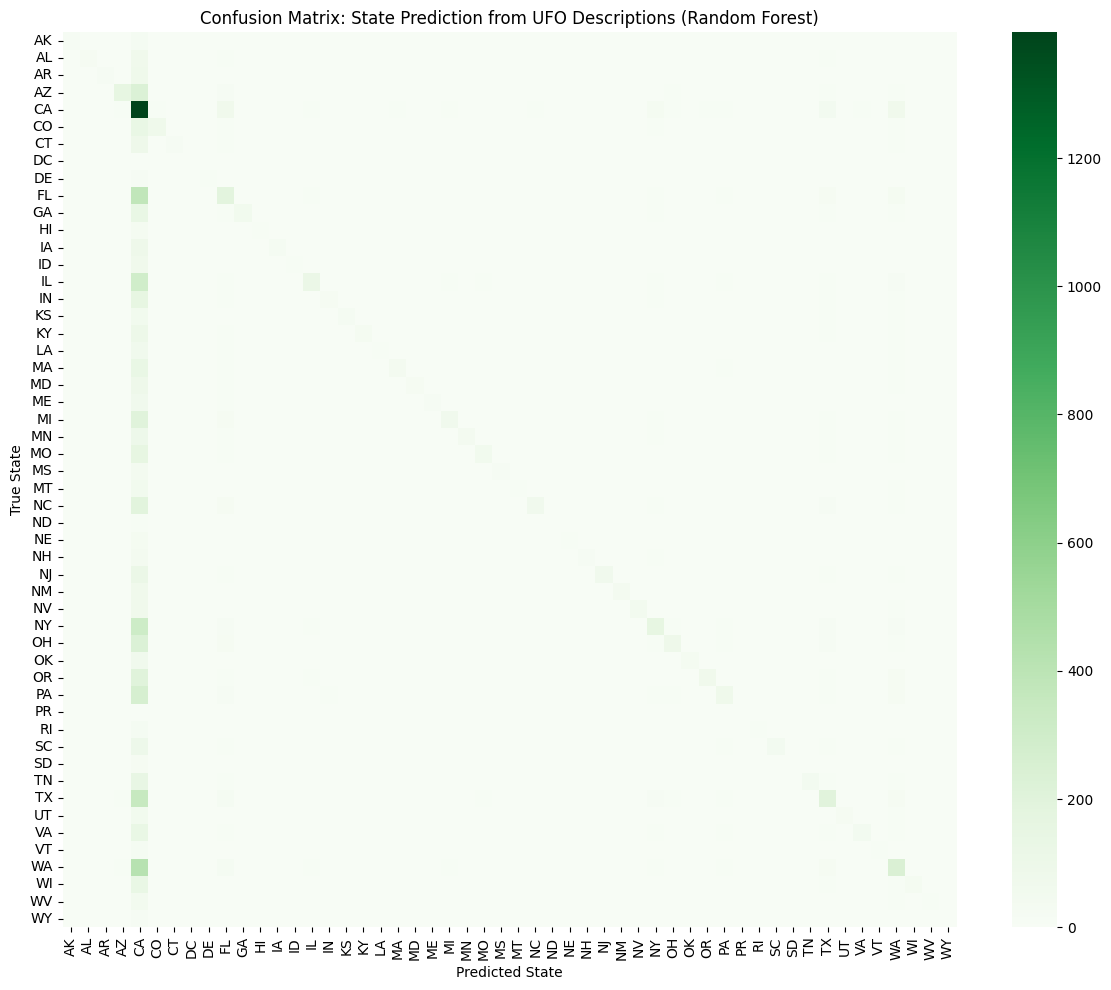

In [9]:
# Confusion matrix - State
cm_state = confusion_matrix(y_test_enc_s, y_pred_s)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_state, annot=False, xticklabels=le_s.classes_, yticklabels=le_s.classes_, cmap='Greens')
plt.title('Confusion Matrix: State Prediction from UFO Descriptions (Random Forest)')
plt.xlabel('Predicted State')
plt.ylabel('True State')
plt.tight_layout()
plt.show()

## US Map Visualization: True vs Predicted State Count

In [10]:
  # US Map Visualization: True vs Predicted State Counts
import plotly.express as px

true_counts = pd.Series(le_s.inverse_transform(y_test_enc_s)).value_counts().sort_index()
pred_counts = pd.Series(le_s.inverse_transform(y_pred_s)).value_counts().sort_index()

map_df = pd.DataFrame({
    'state': true_counts.index,
    'true_count': true_counts.values,
    'pred_count': pred_counts.reindex(true_counts.index, fill_value=0).values
})

fig = px.choropleth(map_df,
                    locations='state',
                    locationmode="USA-states",
                    color='pred_count',
                    scope="usa",
                    title='Predicted UFO Sightings by State (Random Forest)',
                    color_continuous_scale="Purples")
fig.show()